In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Utils import *
from Word2Vec import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style("whitegrid")

In [2]:
text = 'The curious cat chased the elusive mouse through the quiet house. As the sun set, the feline paused to rest, its tail flicking with anticipation. Nearby, the dog barked loudly, startling the bird perched on the windowsill. The mouse, seizing the moment, darted into a small hole in the wall, escaping the cat\'s gaze.'

# Word2Vec: Skip-Gram Implementation

This notebook implements the Skip-Gram architecture of Word2Vec. The goal is to learn vector representations (embeddings) for words based on their context. 

Main Idea: Skip-Gram predicts context words given a center word.

## Preprocessing

### 1. Tokenization

First, the raw text is broken down into individual words or tokens. This typically involves converting to lowercase and removing punctuation.

In [3]:
tokens = tokenize(text)
len(tokens) # Non-unique

54

### 2. Mapping

We create a vocabulary of unique tokens and map each unique word to a unique integer ID. We also create the reverse mapping from ID back to word.

Let the vocabulary be $V = \{w_1, w_2, ..., w_{|V|}\}$, where $|V|$ is the size of the vocabulary (number of unique tokens).

In [4]:
word_to_id, id_to_word = mapping(tokens)
len(word_to_id), len(id_to_word) # Unique

(42, 42)

### 3. Generate Training Data

The Skip-Gram model learns by predicting context words ($w_o$, output) given a center word ($w_c$, input). We generate training pairs $(w_c, w_o)$ by sliding a window of size `window_size` (let's denote it by $m$) across the token sequence.

For each center word $w_i$ at position $i$ in the `tokens` list:
- The context words are $w_j$ where $j$ is in the range $[max(0, i-m), min(N-1, i+m)]$ and $j \neq i$.
- Each pair $(w_i, w_j)$ forms a training sample.

The input $X$ and target $y$ are represented using **one-hot encoding**. For a given pair $(w_c, w_o)$: 
- The input vector $\mathbf{x}_c$ is a vector of size $|V|$ with a 1 at the index corresponding to `word_to_id[w_c]` and 0s elsewhere.
- The target vector $\mathbf{y}_o$ is a vector of size $|V|$ with a 1 at the index corresponding to `word_to_id[w_o]` and 0s elsewhere.

The function `generate_input` creates matrices $X$ and $y$, where each row corresponds to a training pair. The shape is $(N_{pairs}, |V|)$, where $N_{pairs}$ is the total number of generated (center, context) pairs.

In [5]:
X, y = generate_input(tokens, word_to_id)
X.shape, y.shape

((510, 42), (510, 42))

# Skip-Gram Model Architecture

## 1. Initialization

We initialize the neural network parameters. The model has:
- An **input embedding matrix** $\mathbf{W}_1 \in \mathbb{R}^{d \times |V|}$. Each column $j$ of $\mathbf{W}_1$ represents the $d$-dimensional input embedding vector $\mathbf{v}_{w_j}$ for the word with ID $j$.
- An **output embedding matrix** $\mathbf{W}_2 \in \mathbb{R}^{|V| \times d}$. Each row $k$ of $\mathbf{W}_2$ represents the $d$-dimensional output vector $\mathbf{v}'_{w_k}$ for the word with ID $k$.

Here, $d$ is the `embedding_dimension` and $|V|$ is the `vocab_size`.

In [6]:
model = initialize_neural_network(vocab_size=len(word_to_id))

## 2. Training Process

### Forward Propagation

For a batch of $N$ input one-hot vectors $X$ (shape $N \times |V|$):

1.  **Get Center Word Embeddings (Hidden Layer):**
    The embedding for each center word in the batch is retrieved by multiplying $\mathbf{W}_1$ with the input one-hot vector. For the entire batch $X$, this is computed efficiently as:
    $$ \mathbf{H} = \mathbf{W}_1 \mathbf{X}^T \quad (\text{Shape: } d \times N) $$ 
    Each column $\mathbf{h}_i$ of $\mathbf{H}$ is the embedding vector $\mathbf{v}_{c_i}$ for the $i$-th center word in the batch.

2.  **Calculate Scores:**
    Scores for all words in the vocabulary being the context word are calculated using the output matrix $\mathbf{W}_2$. For the entire batch:
    $$ \mathbf{U}_{raw} = \mathbf{W}_2 \mathbf{H} \quad (\text{Shape: } |V| \times N) $$ 
    We transpose this to get scores per sample:
    $$ \mathbf{U} = \mathbf{U}_{raw}^T \quad (\text{Shape: } N \times |V|) $$ 
    Each row $\mathbf{u}_i$ of $\mathbf{U}$ contains the scores $u_{ij} = (\mathbf{v}'_{w_j})^T \mathbf{h}_i$ for the $i$-th sample, predicting the likelihood of word $w_j$ being the context word.

3.  **Apply Softmax:**
    The scores are converted into probabilities using the softmax function applied row-wise to $\mathbf{U}$:
    $$ \mathbf{P}_{ij} = \hat{y}_{ij} = \frac{\exp(u_{ij})}{\sum_{k=1}^{|V|} \exp(u_{ik})} \quad (\text{Shape: } N \times |V|) $$ 
    $\mathbf{P}$ represents the predicted probability distribution over the vocabulary for the context word for each sample in the batch.

### Loss Function (Cross-Entropy)

We use the cross-entropy loss to measure the difference between the predicted probabilities $\mathbf{P}$ (or $\hat{\mathbf{y}}$) and the true one-hot encoded target context words $\mathbf{y}$. For a single sample $(w_c, w_o)$, the loss is:
$$ J = - \sum_{j=1}^{|V|} y_{oj} \log \hat{y}_{oj} = - \log \hat{y}_{oo} $$ 
Where $y_{oj}$ is 1 if $j$ is the index of the true context word $w_o$, and 0 otherwise. $\hat{y}_{oj}$ is the predicted probability of word $w_j$. 

The average loss over the batch of $N$ samples is:
$$ J_{\text{batch}} = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{|V|} y_{ij} \log \hat{y}_{ij} $$

### Backward Propagation (Gradient Calculation)

We aim to compute the gradients of the average batch loss $J_{\text{batch}}$ with respect to the parameters $\mathbf{W}_1$ and $\mathbf{W}_2$ to perform gradient descent.
$$ J_{\text{batch}} = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{|V|} y_{ij} \log p_{ij} $$
where $N$ is the batch size, $y_{ij}$ is the element $(i, j)$ of the target matrix $\mathbf{Y}$, and $p_{ij}$ is the element $(i, j)$ of the predicted probability matrix $\mathbf{P} = \text{softmax}(\mathbf{U})$.

**1. Gradient w.r.t. Scores ($\mathbf{U}$)**

First, we find the gradient of the loss with respect to the pre-softmax scores $\mathbf{U}$. This is a standard result for the derivative of cross-entropy loss with softmax:
$$ \frac{\partial J_{\text{batch}}}{\partial u_{ik}} = \frac{1}{N} (p_{ik} - y_{ik}) $$
In matrix form, let $\mathbf{E} = \mathbf{P} - \mathbf{Y}$ (Shape: $N \times |V|$). Then:
$$ \nabla_{\mathbf{U}} J_{\text{batch}} = \frac{1}{N} \mathbf{E} $$
The matrix $\mathbf{E}$ represents the error between the predicted probabilities and the true one-hot targets for each sample in the batch.

**2. Gradient w.r.t. Output Matrix ($\mathbf{W}_2$)**

We use the chain rule. The loss $J$ depends on $\mathbf{W}_2$ through $\mathbf{U}$. Recall the forward step: $\mathbf{U} = (\mathbf{W}_2 \mathbf{H})^T = \mathbf{H}^T \mathbf{W}_2^T$. Or, looking at the pre-transposed scores $\mathbf{U}_{raw} = \mathbf{W}_2 \mathbf{H}$ (where $\mathbf{U} = \mathbf{U}_{raw}^T$). Let's find the gradient w.r.t. a specific row vector $\mathbf{w}'_k$ (the $k$-th row) of $\mathbf{W}_2$.

The $k$-th score for the $i$-th sample is $u_{ik} = \mathbf{w}'_k \mathbf{h}_i$ (where $\mathbf{h}_i$ is the $i$-th column of $\mathbf{H}$).
$$ \frac{\partial J_{\text{batch}}}{\partial \mathbf{w}'_k} = \sum_{i=1}^{N} \frac{\partial J_{\text{batch}}}{\partial u_{ik}} \frac{\partial u_{ik}}{\partial \mathbf{w}'_k} $$
We know $\frac{\partial J_{\text{batch}}}{\partial u_{ik}} = \frac{1}{N} e_{ik}$ (element $(i,k)$ of $\mathbf{E}$).
From $u_{ik} = \mathbf{w}'_k \mathbf{h}_i$, the derivative $\frac{\partial u_{ik}}{\partial \mathbf{w}'_k} = \mathbf{h}_i^T$.
$$ \frac{\partial J_{\text{batch}}}{\partial \mathbf{w}'_k} = \sum_{i=1}^{N} \left( \frac{1}{N} e_{ik} \right) \mathbf{h}_i^T = \frac{1}{N} \sum_{i=1}^{N} e_{ik} \mathbf{h}_i^T $$
This sum represents the $k$-th row of the matrix product $\frac{1}{N} \mathbf{E}^T \mathbf{H}^T$.

Generalizing to the entire matrix $\mathbf{W}_2$:
$$ \nabla_{\mathbf{W}_2} J_{\text{batch}} = \frac{1}{N} \mathbf{E}^T \mathbf{H}^T \quad (\text{Shape: } |V| \times d) $$
*(This matches the calculation `(E.T @ H.T) / N` in the code.)*

**3. Gradient w.r.t. Hidden Layer ($\mathbf{H}$)**

Next, we need the gradient w.r.t. the hidden layer activations $\mathbf{H}$, as $J$ depends on $\mathbf{H}$ through $\mathbf{U}$. Using the chain rule: $\nabla_{\mathbf{H}} J = \nabla_{\mathbf{U}_{raw}} J \cdot \nabla_{\mathbf{H}} \mathbf{U}_{raw}$.
We use the matrix calculus identity: if $f(Y)$ and $Y=AX$, then $\nabla_X f = A^T \nabla_Y f$.
Here, $f=J$, $Y=\mathbf{U}_{raw}$, $A=\mathbf{W}_2$, $X=\mathbf{H}$.
$\nabla_{\mathbf{U}_{raw}} J = (\nabla_{\mathbf{U}} J)^T = (\frac{1}{N}\mathbf{E})^T = \frac{1}{N}\mathbf{E}^T$.
$$ \nabla_{\mathbf{H}} J_{\text{batch}} = \mathbf{W}_2^T (\nabla_{\mathbf{U}_{raw}} J) = \mathbf{W}_2^T \left( \frac{1}{N} \mathbf{E}^T \right) = \frac{1}{N} \mathbf{W}_2^T \mathbf{E}^T \quad (\text{Shape: } d \times N) $$
This matrix represents the error signal propagated back to the hidden layer.

**4. Gradient w.r.t. Input Matrix ($\mathbf{W}_1$)**

Finally, we find the gradient w.r.t. $\mathbf{W}_1$. The loss $J$ depends on $\mathbf{W}_1$ through $\mathbf{H}$. Recall $\mathbf{H} = \mathbf{W}_1 \mathbf{X}^T$. Let's find the gradient w.r.t. a specific row vector $\mathbf{w}_{1,k}$ (the $k$-th row) of $\mathbf{W}_1$.

The element $(k, i)$ of $\mathbf{H}$ is $h_{ki} = \mathbf{w}_{1,k} \mathbf{x}_i$, where $\mathbf{x}_i$ is the $i$-th column of $\mathbf{X}^T$ (the $i$-th input vector).
$$ \frac{\partial J_{\text{batch}}}{\partial \mathbf{w}_{1,k}} = \sum_{i=1}^{N} \frac{\partial J_{\text{batch}}}{\partial h_{ki}} \frac{\partial h_{ki}}{\partial \mathbf{w}_{1,k}} $$
$\frac{\partial J_{\text{batch}}}{\partial h_{ki}}$ is the element $(k, i)$ of $\nabla_{\mathbf{H}} J_{\text{batch}}$, which is $\frac{1}{N}(\mathbf{W}_2^T \mathbf{E}^T)_{ki}$.
From $h_{ki} = \mathbf{w}_{1,k} \mathbf{x}_i$, the derivative $\frac{\partial h_{ki}}{\partial \mathbf{w}_{1,k}} = \mathbf{x}_i^T$.
$$ \frac{\partial J_{\text{batch}}}{\partial \mathbf{w}_{1,k}} = \sum_{i=1}^{N} \left( \frac{1}{N}(\mathbf{W}_2^T \mathbf{E}^T)_{ki} \right) \mathbf{x}_i^T = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{W}_2^T \mathbf{E}^T)_{ki} \mathbf{x}_i^T $$
This sum represents the $k$-th row of the matrix product $\frac{1}{N}(\mathbf{W}_2^T \mathbf{E}^T) \mathbf{X}$.

Generalizing to the entire matrix $\mathbf{W}_1$:
$$ \nabla_{\mathbf{W}_1} J_{\text{batch}} = \frac{1}{N} (\mathbf{W}_2^T \mathbf{E}^T) \mathbf{X} \quad (\text{Shape: } d \times |V|) $$
*(Note: The code calculates `W2.T @ E.T @ X` without the factor $1/N$. This means the effective learning rate used for updating $\mathbf{W}_1$ in the code is $\alpha / N$ relative to the update for $\mathbf{W}_2$, or equivalently, the gradient magnitude for $\mathbf{W}_1$ is scaled up by $N$. While the direction is correct, this scaling difference is worth noting.)*

### Parameter Update (Gradient Descent)

The weights are updated using Stochastic Gradient Descent (SGD) based on these computed gradients:
$$ \mathbf{W}_1 \leftarrow \mathbf{W}_1 - \alpha \nabla_{\mathbf{W}_1} J_{\text{batch}} $$
$$ \mathbf{W}_2 \leftarrow \mathbf{W}_2 - \alpha \nabla_{\mathbf{W}_2} J_{\text{batch}} $$
Where $\alpha$ is the `learning_rate`.

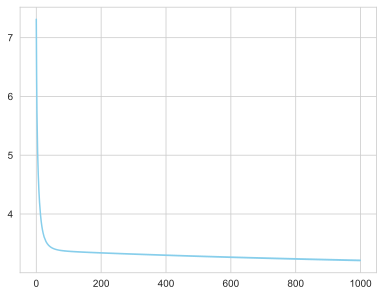

In [7]:
n_iter = 1000
learning_rate = 0.01

history = []

for i in range(n_iter):
    cache = forward(model, X)
    error = backward(model, X, y, cache, learning_rate)
    history.append(error)

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

The plot shows the cross-entropy loss decreasing over the training iterations, indicating that the model is learning to predict context words more accurately. After training, the matrix $\mathbf{W}_1$ (accessed via `model['W1']`) contains the learned word embeddings. The $j$-th column of $\mathbf{W}_1$ is the embedding vector $\mathbf{v}_{w_j}$ for the word with ID $j$.

## 3. Evaluation

In [8]:
# 1. Calculate Final Loss on Training Data
# Perform one last forward pass with the final trained model
final_cache = forward(model, X)
final_loss = cross_entropy(final_cache['P'], y, X.shape[0])
print(f"\n1. Final Cross-Entropy Loss on Training Data: {final_loss:.4f}")


1. Final Cross-Entropy Loss on Training Data: 3.2066


In [9]:
# 2. Predict Context Words for a Given Center Word
def predict_context(center_word, model, word_to_id, id_to_word, top_n=5):
    """Predicts the most likely context words for a given center word."""
    if center_word not in word_to_id:
        print(f"Word '{center_word}' not in vocabulary.")
        return

    vocab_size = len(word_to_id)
    center_id = word_to_id[center_word]
    
    # Create one-hot vector for the center word
    # Need the encode_onehot function from Utils.py
    try:
        center_vec = np.array([encode_onehot(vocab_size, center_id)]) # Shape (1, vocab_size)
    except NameError:
         print("Error: 'encode_onehot' function not found. Make sure it's imported or defined.")
         # Basic implementation if needed:
         center_vec = np.zeros((1, vocab_size))
         center_vec[0, center_id] = 1


    # Perform forward pass for this single word
    cache = forward(model, center_vec)
    pred_probs = cache['P'][0] # Probabilities for the context word (shape: vocab_size)

    # Get the indices of the top N predictions
    top_indices = np.argsort(pred_probs)[::-1][:top_n]

    print(f"\n2. Top {top_n} predicted context words for '{center_word}':")
    for i in top_indices:
        print(f"   - {id_to_word[i]} (Probability: {pred_probs[i]:.4f})")

# Example prediction:
predict_context('cat', model, word_to_id, id_to_word, top_n=5)
predict_context('mouse', model, word_to_id, id_to_word, top_n=5)


2. Top 5 predicted context words for 'cat':
   - the (Probability: 0.2234)
   - mouse (Probability: 0.1201)
   - chased (Probability: 0.1082)
   - curious (Probability: 0.0693)
   - as (Probability: 0.0613)

2. Top 5 predicted context words for 'mouse':
   - the (Probability: 0.1704)
   - chased (Probability: 0.0678)
   - into (Probability: 0.0613)
   - quiet (Probability: 0.0594)
   - perched (Probability: 0.0582)


In [10]:
# 3. Find Similar Words (using Cosine Similarity on Input Embeddings W1)
def cosine_similarity(vec_a, vec_b):
    """Calculates cosine similarity between two vectors."""
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return dot_product / (norm_a * norm_b)

def find_similar_words(target_word, model, word_to_id, id_to_word, top_n=5):
    """Finds words with embeddings most similar to the target word."""
    if target_word not in word_to_id:
        print(f"Word '{target_word}' not in vocabulary.")
        return

    target_id = word_to_id[target_word]
    # Use W1 (input embeddings) as the primary embeddings
    W1 = model['W1'] # Shape (embedding_dim, vocab_size)
    target_vec = W1[:, target_id] # Embedding of the target word

    similarities = {}
    for word, word_id in word_to_id.items():
        if word == target_word:
            continue
        other_vec = W1[:, word_id]
        similarities[word] = cosine_similarity(target_vec, other_vec)

    # Sort words by similarity
    sorted_similar = sorted(similarities.items(), key=lambda item: item[1], reverse=True)

    print(f"\n3. Top {top_n} words most similar to '{target_word}':")
    for word, sim in sorted_similar[:top_n]:
        print(f"   - {word} (Similarity: {sim:.4f})")

# Example similarity check:
find_similar_words('cat', model, word_to_id, id_to_word, top_n=5)
find_similar_words('house', model, word_to_id, id_to_word, top_n=5)


3. Top 5 words most similar to 'cat':
   - chased (Similarity: 0.8870)
   - quiet (Similarity: 0.8714)
   - the (Similarity: 0.8357)
   - windowsill (Similarity: 0.8334)
   - house (Similarity: 0.8289)

3. Top 5 words most similar to 'house':
   - quiet (Similarity: 0.9128)
   - windowsill (Similarity: 0.8598)
   - cat (Similarity: 0.8289)
   - bird (Similarity: 0.7688)
   - as (Similarity: 0.7423)


d:\Download\Anaconda\envs\DeepML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Performing UMAP reduction to 3 dimensions (n_neighbors=5, min_dist=0.3)...


d:\Download\Anaconda\envs\DeepML\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Download\Anaconda\envs\DeepML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduction complete.


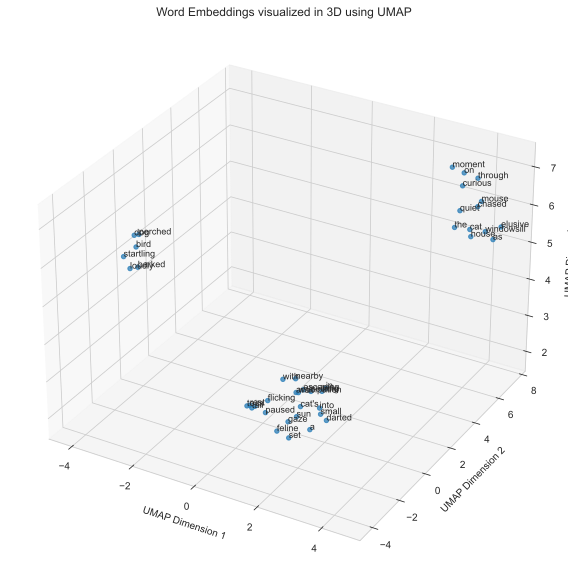

In [11]:
# --- Add this cell ---
import umap # Uniform Manifold Approximation and Projection
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

# --- Add this cell ---
def plot_embeddings_3d_umap(model, id_to_word, umap_neighbors=5, umap_min_dist=0.3, figsize=(12, 10)):
    """
    Reduces word embeddings to 3D using UMAP and plots them, labeling points with words.

    Args:
        model (dict): The trained Word2Vec model dictionary containing 'W1'.
        id_to_word (dict): Dictionary mapping word IDs back to word strings.
        umap_neighbors (int): UMAP's n_neighbors parameter. Controls local vs global structure.
        umap_min_dist (float): UMAP's min_dist parameter. Controls how tightly points are packed.
        figsize (tuple): Size of the matplotlib figure.
    """
    # Extract the input embedding matrix (embeddings are columns)
    embedding_matrix = model['W1']
    vocab_size = embedding_matrix.shape[1]

    # --- Dimensionality Reduction using UMAP ---
    print(f"Performing UMAP reduction to 3 dimensions (n_neighbors={umap_neighbors}, min_dist={umap_min_dist})...")
    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=umap_neighbors,
        min_dist=umap_min_dist,
        metric='cosine',  # Cosine distance often works well for word embeddings
        random_state=42  # for reproducibility
    )

    # UMAP expects samples as rows, our embeddings are columns in W1
    embeddings_for_umap = embedding_matrix.T
    umap_3d_embeddings = reducer.fit_transform(embeddings_for_umap)
    print("UMAP reduction complete.")

    # --- Plotting ---
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot the 3D points
    ax.scatter(umap_3d_embeddings[:, 0], umap_3d_embeddings[:, 1], umap_3d_embeddings[:, 2], alpha=0.7)

    # Add word labels to each point
    for i in range(vocab_size):
        word = id_to_word.get(i, f"ID_{i}") # Get word from ID, fallback if missing
        ax.text(umap_3d_embeddings[i, 0],
                umap_3d_embeddings[i, 1],
                umap_3d_embeddings[i, 2],
                word,
                fontsize=9) # Adjust fontsize as needed

    ax.set_title('Word Embeddings visualized in 3D using UMAP')
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')
    plt.grid(True) # Add grid for better visualization
    plt.show()

# --- Add this cell ---

# Ensure 'model' and 'id_to_word' are available from previous cells
if 'model' in locals() and 'id_to_word' in locals():
    # You might need to adjust umap_neighbors and umap_min_dist based on your vocab size
    # For very small vocabularies (like the example text), smaller neighbors might be okay.
    # Defaults are n_neighbors=15, min_dist=0.1
    plot_embeddings_3d_umap(model, id_to_word, umap_neighbors=5, umap_min_dist=0.3)
else:
    print("Please ensure the 'model' and 'id_to_word' variables are defined from previous steps.")

# Conclusion

Okay, let's discuss the strengths and weaknesses of Word2Vec (both Skip-gram and CBOW) and how the field has evolved to address its limitations.

**Pros of Word2Vec:**

1.  **Captures Semantic Relationships:** This was its groundbreaking contribution. Word2Vec embeddings can capture analogies (e.g., "king" - "man" + "woman" ≈ "queen") and semantic similarity (e.g., "cat" and "dog" vectors are closer than "cat" and "car"). This demonstrated that meaning could be learned from distributional patterns in text.
2.  **Produces Dense Embeddings:** It generates low-dimensional, dense vectors (typically 50-1000 dimensions) which are much more efficient storage-wise and computationally than high-dimensional sparse representations like one-hot vectors.
3.  **Cost-Efficient:** The neural network architecture behind Word2Vec is simple and leverage unsupervised learning.

**Cons of Word2Vec:**

1.  **Inability to Handle Out-of-Vocabulary (OOV) Words:** If a word was not present in the training corpus, Word2Vec cannot generate an embedding for it.
2.  **Single Vector for Polysemous Words:** Word2Vec assigns only *one* vector representation to each word string. It cannot differentiate between different meanings of the same word (e.g., "bank" as a river bank vs. a financial institution). The resulting vector is often a blend of its various contexts.
3.  **Ignores Word Morphology:** It treats words as atomic units. It doesn't inherently understand that "run", "running", and "ran" are related forms of the same root verb, assigning them potentially very different vectors unless they appear in extremely similar contexts across the corpus.
4.  **Limited Use of Context:** While based on context, it only considers a local window of neighboring words. It doesn't effectively capture longer-range dependencies, sentence structure, or global topic information. Word order within the context window is also largely ignored (especially by CBOW).

**Addressing the Issues / Mitigation Strategies:**

The limitations of Word2Vec spurred significant research, leading to more advanced techniques:

1.  **Handling OOV & Morphology:**
    *   **FastText:** Developed by Facebook AI Research (also involving Tomas Mikolov, one of Word2Vec's authors). FastText represents words as bags of **character n-grams** (e.g., "apple" -> <ap, app, ppl, ple, le>, <app, ppl, ...> plus the whole word ). The final word embedding is the sum of its character n-gram vectors. This allows it to:
        *   Share representations between morphologically similar words (e.g., "running" and "runner" share n-grams like "runn").
        *   Generate embeddings for OOV words by summing the vectors of their constituent character n-grams (assuming those n-grams were seen in other words during training).
    *   **Subword Tokenization (BPE, WordPiece, SentencePiece):** Used heavily in modern Transformer models. These algorithms break words into common subword units based on frequency in the corpus. This handles morphology better than whole words and significantly reduces the OOV problem, as rare words can often be represented by common subwords.

2.  **Handling Polysemy & Static Embeddings:**
    *   **Contextual Embeddings:** Prefer models like **ELMo**, **BERT**, **GPT**, **RoBERTa**, **XLNet**, etc., generate word embeddings that are *context-dependent*. The vector for "bank" in "river bank" will be different from the vector for "bank" in "money in the bank". They achieve this using deeper architectures (LSTMs for ELMo, Transformers for the others) that process the entire input sequence to produce representations for each token. These models effectively address the polysemy and static nature limitations.

3.  **Capturing Longer Context & Word Order:**
    *   **Recurrent Neural Networks (RNNs, LSTMs, GRUs):** Process sequences token by token, maintaining a hidden state that encodes information from previous tokens, thus capturing order and longer dependencies (though LSTMs/GRUs are better at longer ranges than basic RNNs).
    *   **Transformers (Self-Attention):** The dominant architecture now. Self-attention mechanisms allow the model to directly weigh the importance of all other words in the sequence when computing the representation for a given word, enabling the capture of very long-range dependencies and complex syntactic relationships far more effectively than previous methods. Contextual embedding models (BERT, GPT, etc.) are based on Transformers.